In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sys
import os
from tensorflow.keras.applications.vgg16 import VGG16
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from PIL import Image

In [5]:

traindir = r"H:\Thesis\Thesis work Version 7\Dataset_V_7_Thesis\train"
testdir = r"H:\Thesis\Thesis work Version 7\Dataset_V_7_Thesis\test"
validdir = r"H:\Thesis\Thesis work Version 7\Dataset_V_7_Thesis\val"

In [6]:
# Function to load RGB images from a folder with labels inferred from subdirectories
def load_images(folder):
    images = []
    targets = []
    class_folders = os.listdir(folder)
    for class_folder in class_folders:
        class_path = os.path.join(folder, class_folder)
        if not os.path.isdir(class_path):
            continue  # Skip non-directory entries
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            if not os.path.isfile(img_path):
                continue  # Skip non-file entries
            img = Image.open(img_path).convert('RGB')  # Keep RGB format
            img = img.resize((128, 128))
            img_array = np.array(img)
            images.append(img_array)

            # Extract target label from parent folder name (class name)
            target = class_folder
            targets.append(target)
    return np.array(images), np.array(targets)

In [7]:
# Load training, validation, and test data
input_train, target_train = load_images(traindir)
input_valid, target_valid = load_images(validdir)
input_test, target_test = load_images(testdir)

In [8]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], 128, 128, 3)  # Use 3 channels
input_valid = input_valid.reshape(input_valid.shape[0], 128, 128, 3)  # Use 3 channels
input_test = input_test.reshape(input_test.shape[0], 128, 128, 3)  # Use 3 channels
input_shape = (128, 128, 3)  # Adjust input shape for RGB images

In [9]:
# Parse numbers as floats
input_train = input_train.astype('float32')
input_valid = input_valid.astype('float32')
input_test = input_test.astype('float32')

In [10]:
# Convert into [0, 1] range
input_train = input_train / 255
input_valid = input_valid / 255
input_test = input_test / 255

In [11]:
# Create a dictionary to map string labels to numeric values
label_to_index = {label: index for index, label in enumerate(np.unique(target_train))}

In [12]:
# Print the label-to-index mapping
print("Label to Index Mapping:")
for label, index in label_to_index.items():
    print(f"Label: {label} -> Index: {index}")

Label to Index Mapping:
Label: Apple___Apple_scab -> Index: 0
Label: Apple___Black_rot -> Index: 1
Label: Apple___Cedar_apple_rust -> Index: 2
Label: Apple___healthy -> Index: 3
Label: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot -> Index: 4
Label: Corn_(maize)___Common_rust_ -> Index: 5
Label: Corn_(maize)___Northern_Leaf_Blight -> Index: 6
Label: Corn_(maize)___healthy -> Index: 7
Label: Grape___Black_rot -> Index: 8
Label: Grape___Esca_(Black_Measles) -> Index: 9
Label: Grape___Leaf_blight_(Isariopsis_Leaf_Spot) -> Index: 10
Label: Grape___healthy -> Index: 11
Label: Tomato___Bacterial_spot -> Index: 12
Label: Tomato___Early_blight -> Index: 13
Label: Tomato___Late_blight -> Index: 14
Label: Tomato___healthy -> Index: 15


In [13]:
# Convert string labels to numeric values using label_to_index mapping
target_train_indices = np.array([label_to_index[label] for label in target_train])
target_test_indices = np.array([label_to_index[label] for label in target_test])
target_valid_indices = np.array([label_to_index[label] for label in target_valid])

In [14]:
from tensorflow.keras.utils import to_categorical

In [15]:
# Convert numeric labels to categorical targets
target_train_categorical = to_categorical(target_train_indices, num_classes=16)
target_valid_categorical = to_categorical(target_valid_indices, num_classes=16)
target_test_categorical = to_categorical(target_test_indices, num_classes=16)

In [16]:
# Print the shape of data and targets after preprocessing
print("Input shape (train):", input_train.shape)
print("Input shape (validation):", input_valid.shape)
print("Input shape (test):", input_test.shape)
print("Target shape (train):", target_train_categorical.shape)
print("Target shape (validation):", target_valid_categorical.shape)
print("Target shape (test):", target_test_categorical.shape)

Input shape (train): (22488, 128, 128, 3)
Input shape (validation): (6425, 128, 128, 3)
Input shape (test): (3214, 128, 128, 3)
Target shape (train): (22488, 16)
Target shape (validation): (6425, 16)
Target shape (test): (3214, 16)


In [17]:
base_model=VGG16(include_top=False,input_shape=(128,128,3))
base_model.trainable=False

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten, Dense, Dropout


In [23]:
classifier=Sequential()
classifier.add(base_model)
classifier.add(Flatten())
classifier.add(layers.Dense(256, activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(16,activation='softmax'))
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4112      
Total params: 16,816,208
Trainable params: 2,101,520
Non-trainable params: 14,714,688
_________________________________________________________________


In [24]:
classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# Data augmentation setup
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(input_train, target_train_categorical, batch_size=32)
valid_generator = valid_datagen.flow(input_valid, target_valid_categorical, batch_size=32)

In [26]:
# Train the model with data augmentation
history = classifier.fit(
    train_generator,
    
    steps_per_epoch=len(input_train) // 32,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=len(input_valid) // 32
)

Epoch 1/20
702/702 [==============================] - 1909s 3s/step - loss: 0.9156 - accuracy: 0.6797 - val_loss: 0.4078 - val_accuracy: 0.8491
Epoch 2/20
702/702 [==============================] - 1900s 3s/step - loss: 0.5890 - accuracy: 0.7825 - val_loss: 0.3659 - val_accuracy: 0.8595
Epoch 3/20
702/702 [==============================] - 1892s 3s/step - loss: 0.5288 - accuracy: 0.8022 - val_loss: 0.3473 - val_accuracy: 0.8619
Epoch 4/20
702/702 [==============================] - 1886s 3s/step - loss: 0.5038 - accuracy: 0.8110 - val_loss: 0.3441 - val_accuracy: 0.8634
Epoch 5/20
702/702 [==============================] - 1895s 3s/step - loss: 0.4714 - accuracy: 0.8235 - val_loss: 0.2856 - val_accuracy: 0.8908
Epoch 6/20
702/702 [==============================] - 1893s 3s/step - loss: 0.4554 - accuracy: 0.8280 - val_loss: 0.2868 - val_accuracy: 0.8891
Epoch 7/20
702/702 [==============================] - 1898s 3s/step - loss: 0.4418 - accuracy: 0.8351 - val_loss: 0.3328 - val_accuracy:

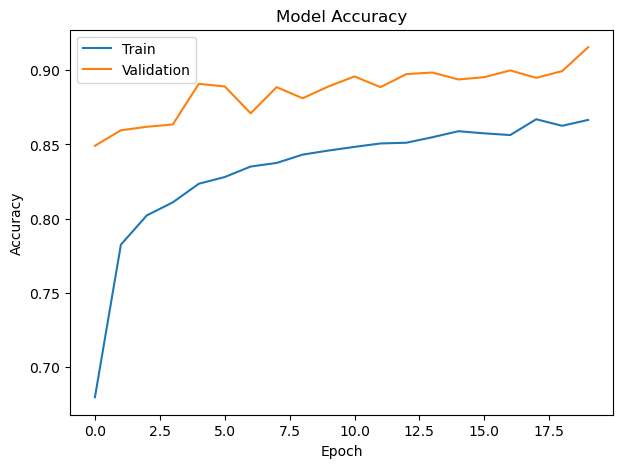

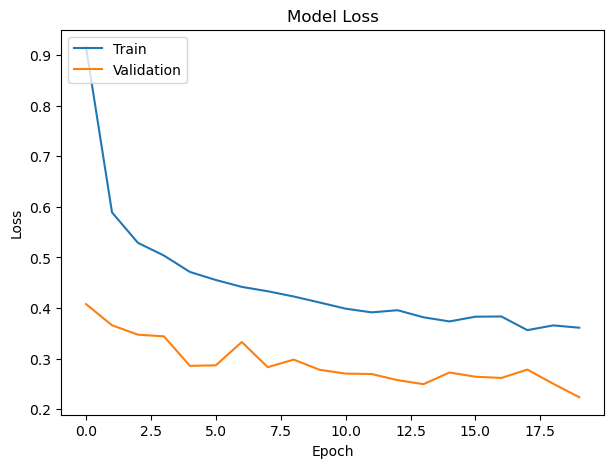

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Plotting the accuracy and loss curves
def plot_metrics(history):
    # Plot accuracy
    plt.figure(figsize=(7, 5))  # Set figure size to 7x5 inches
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot loss
    plt.figure(figsize=(7, 5))  # Set figure size to 7x5 inches
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Example usage:
# Assuming you have a `history` object from training your model
# Replace this with your actual history object
history = history  # Replace with your actual history object from model training

plot_metrics(history)


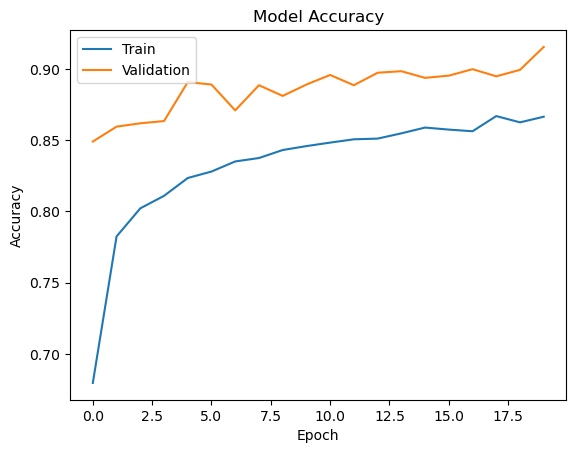

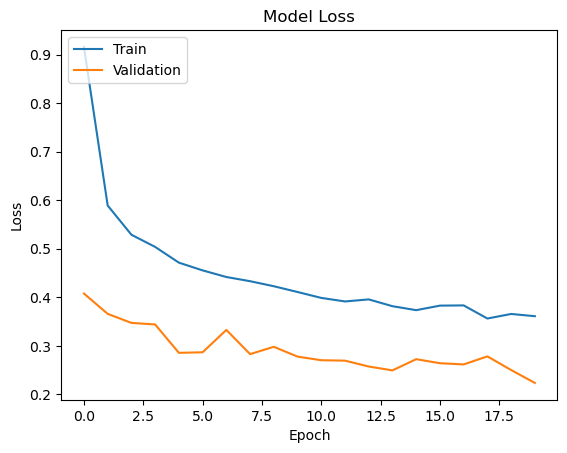

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Plotting the accuracy and loss curves
def plot_metrics(history):
    # Plot accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Evaluate the model
plot_metrics(history)

In [36]:
import matplotlib.pyplot as plt
import os

# Function to plot and save accuracy and loss curves
def plot_metrics(history, save_path):
    # Ensure the save path exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Plot accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    accuracy_plot_path = os.path.join(save_path, 'accuracy_curve.png')
    plt.savefig(accuracy_plot_path)
    plt.close()  # Close the plot to free memory
    
    # Plot loss
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    loss_plot_path = os.path.join(save_path, 'loss_curve.png')
    plt.savefig(loss_plot_path)
    plt.close()  # Close the plot to free memory

    print(f"Accuracy and Loss curves saved at: {save_path}")

# Specify the path where the plots will be saved
save_directory = r"C:\Users\HP\OneDrive\Desktop\Thesis Trained Model\Vgg16"

# Call the function to plot and save the curves
plot_metrics(history, save_directory)


Accuracy and Loss curves saved at: C:\Users\HP\OneDrive\Desktop\Thesis Trained Model\Vgg16


In [29]:
from sklearn.metrics import classification_report

# Make predictions on test data
predictions = classifier.predict(input_test)

# Convert predictions from one-hot encoded format to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels from one-hot encoded format to class labels
true_classes = np.argmax(target_test_categorical, axis=1)

# Generate classification report
report = classification_report(true_classes, predicted_classes)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       200
           1       0.92      0.93      0.93       200
           2       0.98      0.92      0.95       200
           3       0.92      0.95      0.94       200
           4       0.85      0.89      0.87       200
           5       0.99      0.99      0.99       200
           6       0.85      0.83      0.84       200
           7       0.99      0.94      0.97       200
           8       0.83      0.84      0.83       200
           9       0.86      0.83      0.85       200
          10       0.96      0.98      0.97       200
          11       0.97      0.98      0.97       200
          12       0.93      0.98      0.96       214
          13       0.89      0.79      0.83       200
          14       0.88      0.91      0.89       200
          15       0.95      0.98      0.97       200

    accuracy                           0.92      3214
   

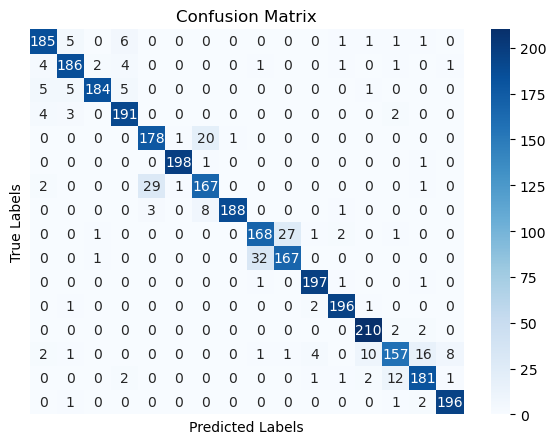

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the classes
classes = []  # Replace with your class names

# Get the true class labels for the test set
true_labels = [label_to_index[label] for label in target_test]

# Get the predicted class labels for the test set
predicted_labels = [np.argmax(prediction) for prediction in classifier.predict(input_test)]

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the true class labels for the test set
true_labels = test_generator.classes

# Get the predicted class labels for the test set
predicted_labels = np.argmax(model.predict(test_generator), axis=-1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix without labels
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the confusion matrix plot to the specified location
save_path = r"C:\Users\HP\OneDrive\Desktop\Thesis Trained Model\Vgg16\confusion_matrix_no_labels.png"
plt.savefig(save_path)
plt.close()

print(f'Confusion matrix saved at {save_path}')


NameError: name 'test_generator' is not defined

In [31]:
from tensorflow.keras.models import load_model 
classifier.save(r"C:\Users\HP\OneDrive\Desktop\Thesis Trained Model\Vgg16\vgg16v2")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\HP\OneDrive\Desktop\Thesis Trained Model\Vgg16\vgg16v2\assets


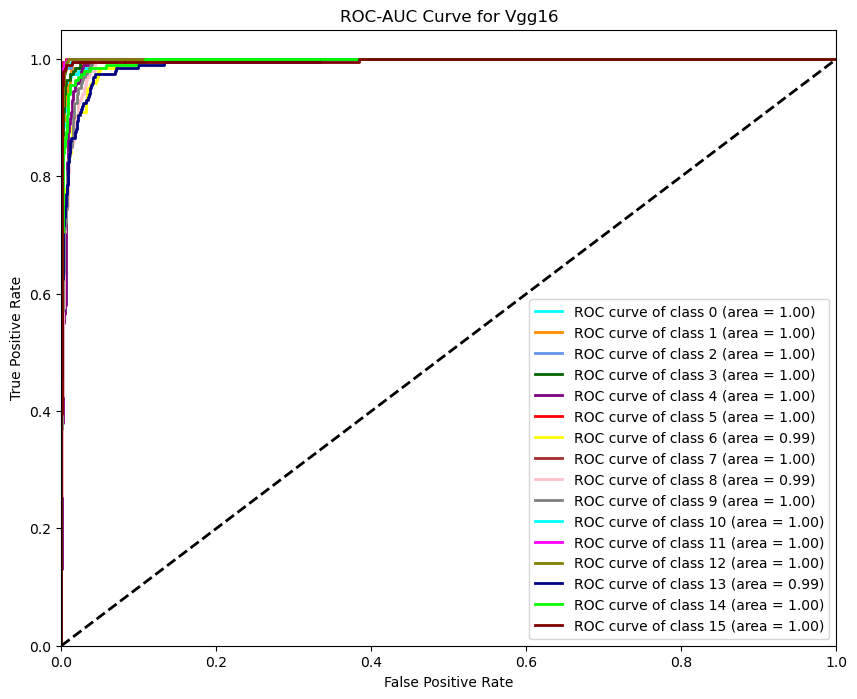

In [39]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Get predictions for the test set
y_pred = classifier.predict(input_test)

# Binarize the labels for ROC calculation
y_test_binarized = label_binarize(target_test_indices, classes=np.arange(16))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(16):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple', 'red', 'yellow', 'brown', 'pink', 'grey', 'cyan', 'magenta', 'olive', 'navy', 'lime', 'maroon'])
for i, color in zip(range(16), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Vgg16')
plt.legend(loc="lower right")
plt.show()


In [35]:
# Evaluate the model on test data
test_loss, test_accuracy = classifier.evaluate(input_test, target_test_categorical)

# Print test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the model on a different dataset (e.g., validation data)
val_loss, val_accuracy = classifier.evaluate(input_valid, target_valid_categorical)

# Print validation loss and accuracy
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


import numpy as np

# Predict the classes for the test set
predictions = classifier.predict(input_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(target_test_categorical, axis=1)

# Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)

# Print the accuracy
print("Calculated Accuracy:", accuracy)

101/101 [==============================] - 219s 2s/step - loss: 0.2320 - accuracy: 0.9175
Test Loss: 0.23197589814662933
Test Accuracy: 0.9175482392311096
201/201 [==============================] - 424s 2s/step - loss: 0.2234 - accuracy: 0.9156
Validation Loss: 0.22344394028186798
Validation Accuracy: 0.9156420230865479
Calculated Accuracy: 0.917548226509023
